## Import code

In [ ]:
%load_ext autoreload
%autoreload 2 
# Autoreloads packages when changes are detected

from src.Data import * # Class containing the data
from src.Assignment import * # Class containing an assignment
from src.Model import * # Class containing a Pulp model used for optimization
from src.ModelColumnGen import * # Class containing Pulp model that optimizes using column generation
from src.ModelFracStable import * # Class containing a Pulp model for finding an fractionally stable stochastic improvement
from src.ModelHeuristicLP import * # Class containing heuristic that will use generated weakly stable matchings as an input
from src.DataGen import * # Generate student preferences and school priorities
from src.DataGenEE import * # Generate data according to the method by Erdil & Ergin (2008)
from src.DA_STB import * # Generate DA assignment with single tie-breaking (STB)
from src.ErdilErgin import * # Erdil & Ergil their implementation of Stable Improvement Cycles algorithm + alternative implementation DA
from src.SICs import * # Adaptation of SICs algorithm to our code

from ReadData.Estonia.Estonia import * # Read Estonian data

import pickle # to export data

# If you get error that pulp and gurobipy are not installed: uncomment following lines in src/Data file:(keep exclamation marks)
    #! pip install pulp
    #! pip install gurobipy

## Column generation formulation

In [9]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
#[n_students,n_schools,seed] = [40,10,10]
[n_students,n_schools,seed] = [50,12,10] # Nice, good illustration of results!
#[n_students,n_schools,seed] = [35,15,0] # Clean simple example where EE has no improvement and we have
name = str(n_students) + "_" + str(n_schools) + "_" + str(seed)
MyData = generate_data(n_students = n_students, n_schools=n_schools, parameters = parameters, name=name, print_data=False, seed = seed)

In [10]:
# Print data if desired
print(MyData)

The data instance has the following properties: 

	50 students.
	12 schools. 

 	PREFERENCES:
	0	6 4 7 2 
	1	1 4 8 
	2	0 7 3 2 
	3	6 4 0 10 11 1 
	4	7 2 4 10 6 0 
	5	0 5 11 3 6 
	6	1 10 4 6 
	7	3 10 5 
	8	0 10 3 2 4 
	9	6 11 2 4 
	10	7 11 10 3 2 
	11	4 1 11 10 5 7 
	12	9 4 11 10 8 
	13	5 1 10 11 6 
	14	3 11 9 4 8 
	15	4 0 1 7 
	16	3 0 4 10 
	17	1 3 11 0 
	18	4 1 9 0 11 
	19	1 11 6 4 7 
	20	4 3 11 6 
	21	6 11 0 1 10 7 
	22	4 11 6 3 1 
	23	7 3 8 
	24	2 8 5 4 0 
	25	1 5 11 7 
	26	1 7 4 
	27	1 4 3 11 8 
	28	3 10 4 11 
	29	9 4 6 7 
	30	7 1 3 4 8 
	31	1 11 
	32	1 10 3 
	33	6 1 7 0 
	34	7 1 9 2 11 
	35	6 2 0 4 
	36	11 4 9 
	37	0 4 11 
	38	4 0 10 9 
	39	2 7 11 3 0 
	40	11 4 7 
	41	8 0 
	42	2 8 10 4 
	43	6 11 7 10 
	44	9 7 4 3 
	45	5 4 8 0 2 
	46	7 6 2 0 1 
	47	11 4 1 0 
	48	10 1 6 5 
	49	6 11 4 0 8 


 	CAPACITIES & PRIORITIES:
	0	1	{36 35 43 0 4 46 29 11 18 2 30 38 25 47 42 31} {6 19 14 10 40 16 3 22 49 13 17 33 26 15 41 45} {27 23 34 37 1 24 32 7 48 8 12 39 44 5 28 21 9 20} 
	1	3	{15 5 11 21

In [11]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 200
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

Students in ties: 50
Tie-breaking rules needed: 30414093201713378043612608166064768844377641568960512000000000000
Tie-breaking rules sampled: 200


Generate DA_STB: 100%|██████████| 200/200 [00:00<00:00, 237.82perturb/s]


STATISTICS BEFORE:

Average rank: 1.4952000000000003.

STATISTICS AFTER:

Average rank: 1.4292000000000016.



In [16]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
    
S = MyModel.Solve("TRAD", "GUROBI", print_log=False, time_limit= 300, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 163/163 [00:00<00:00, 1814.58var/s]
c:\Users\tdemeule\AppData\Local\anaconda3\Lib\site-packages\pulp\pulp.py:1423: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")



Average rank DA : 1.4952000000000003.


Average rank warm start solution : 1.4292000000000016.




Pricing exclude found matchings: 100%|██████████| 163/163 [00:00<00:00, 878.63matchings/s]


Number of matchings: 163
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.400400000000001
Constant term -2.2800000000000016

 ****** PRICING ****** 

Set parameter BestObjStop to value 2.2801000000000018e+00
		Objective pricing:  0.18000000000000194
New number of matchings: 164
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.400400000000001
Constant term -2.280000000000005

 ****** PRICING ****** 

Set parameter BestObjStop to value 2.2801000000000053e+00
		Objective pricing:  0.20000000000000284
New number of matchings: 165
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.4004000000000003
Constant term -2.280000000000004

 ****** PRICING ****** 

Set parameter BestObjStop to value 2.2801000000000040e+00
		Objective pricing:  0.13999999999999924
New number of matchings: 166
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.400400000000001
Constant term -2.2800000000000007

 ****** PRICING ****** 

Set parameter BestObjStop to value 2.280100000000

In [17]:
print(S.A.assignment)
print(S.Xdecomp)
print(S.Xdecomp_coeff)

[[0.         0.         0.         0.         0.         0.
  0.82       0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.        ]
 [0.905      0.         0.         0.         0.         0.
  0.         0.095      0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.09333333 0.         0.         0.         0.
  0.         0.         0.         0.         0.88166667 0.        ]
 [0.         0.         0.         0.995      0.         0.
  0.         0.         0.         0.

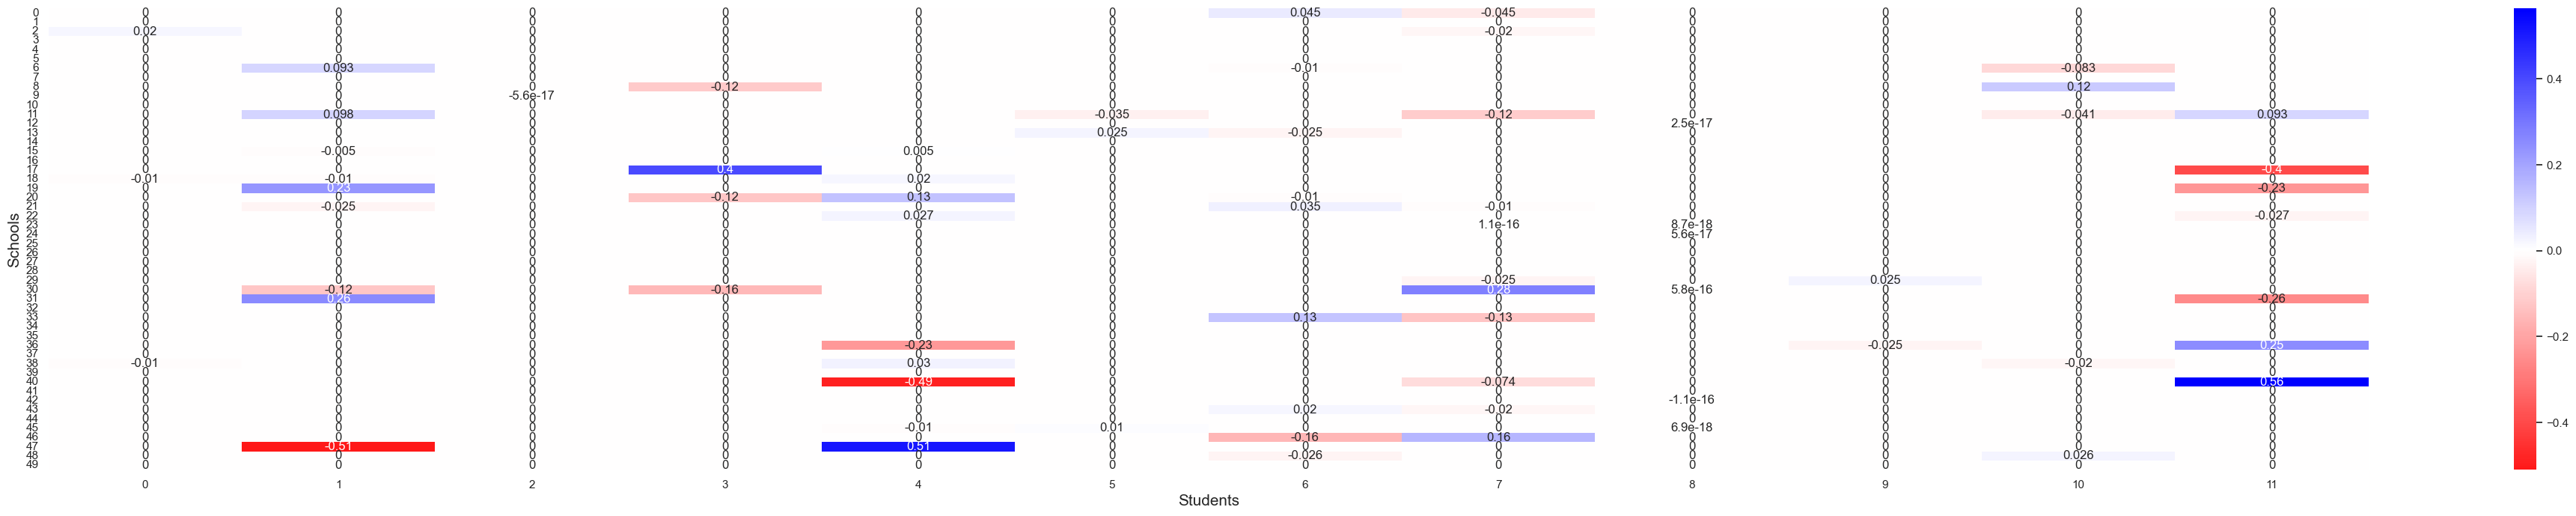

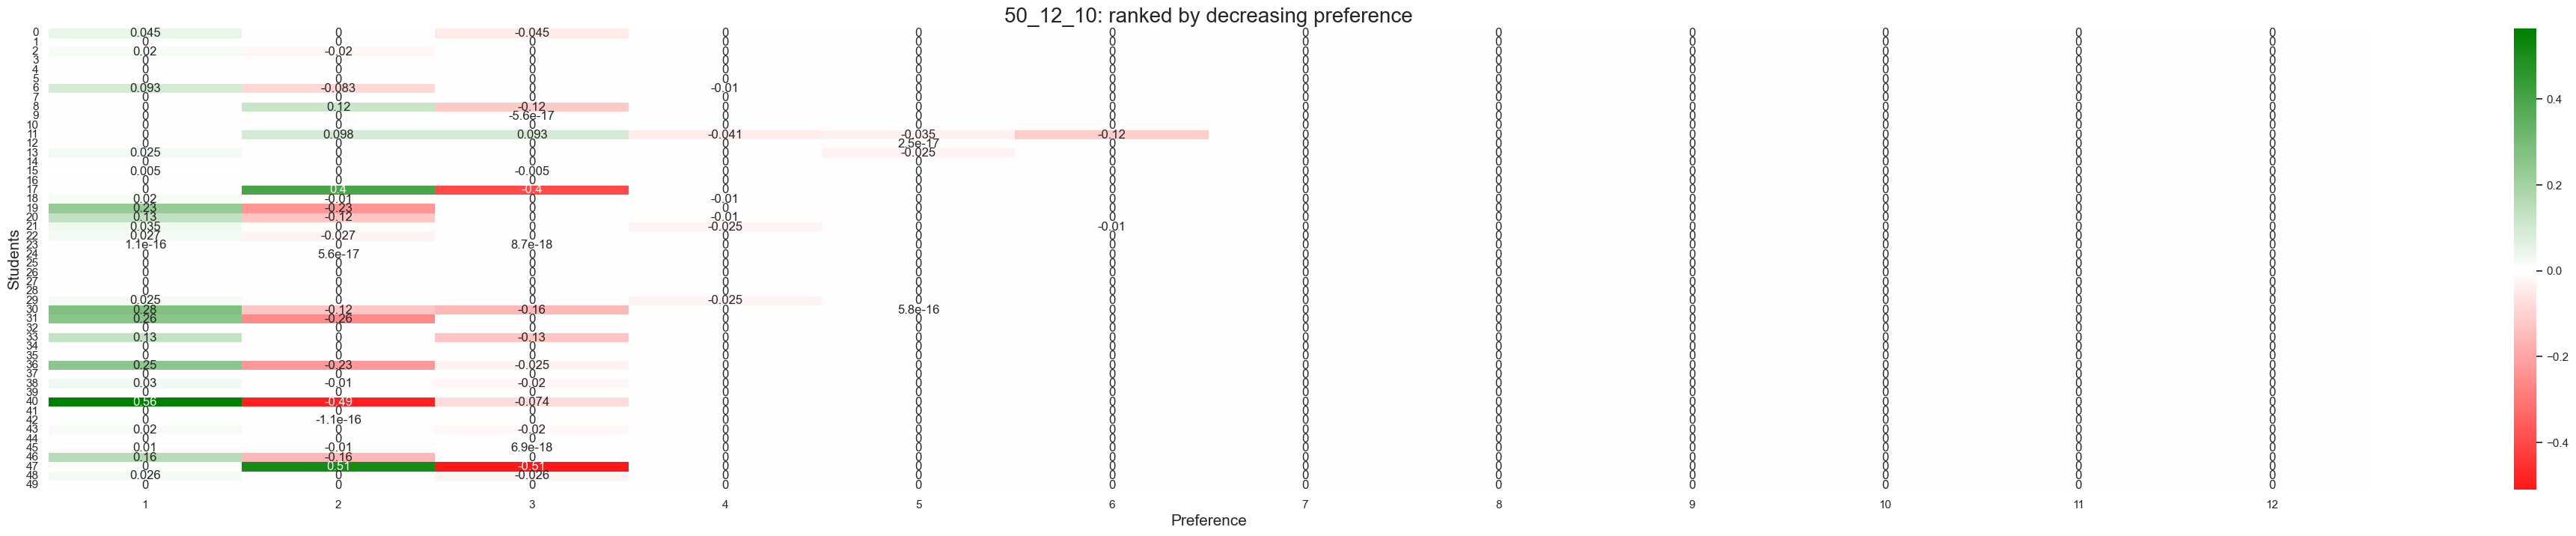

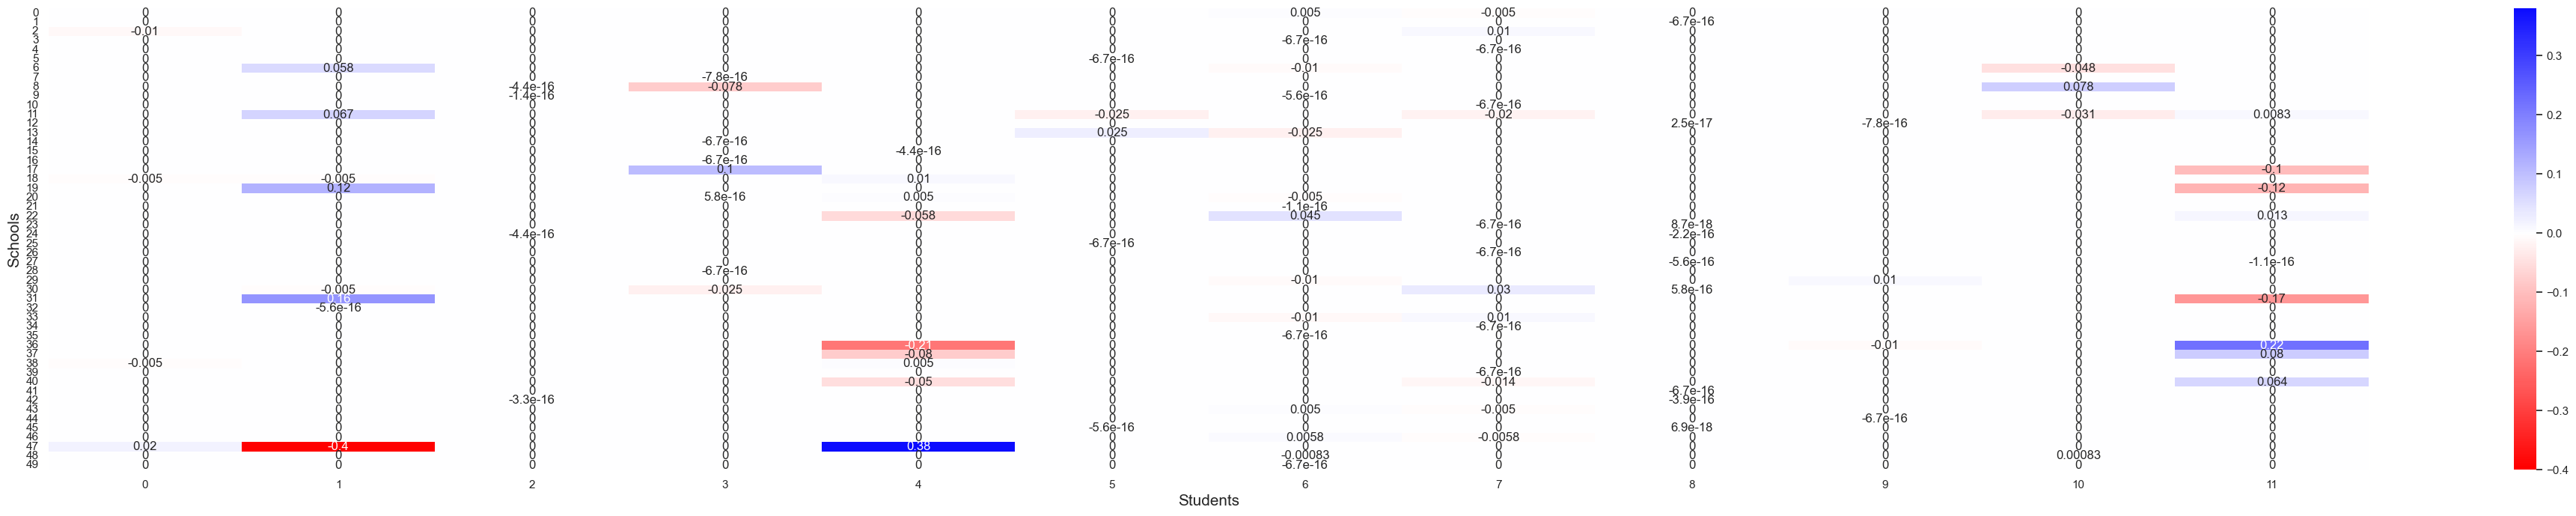

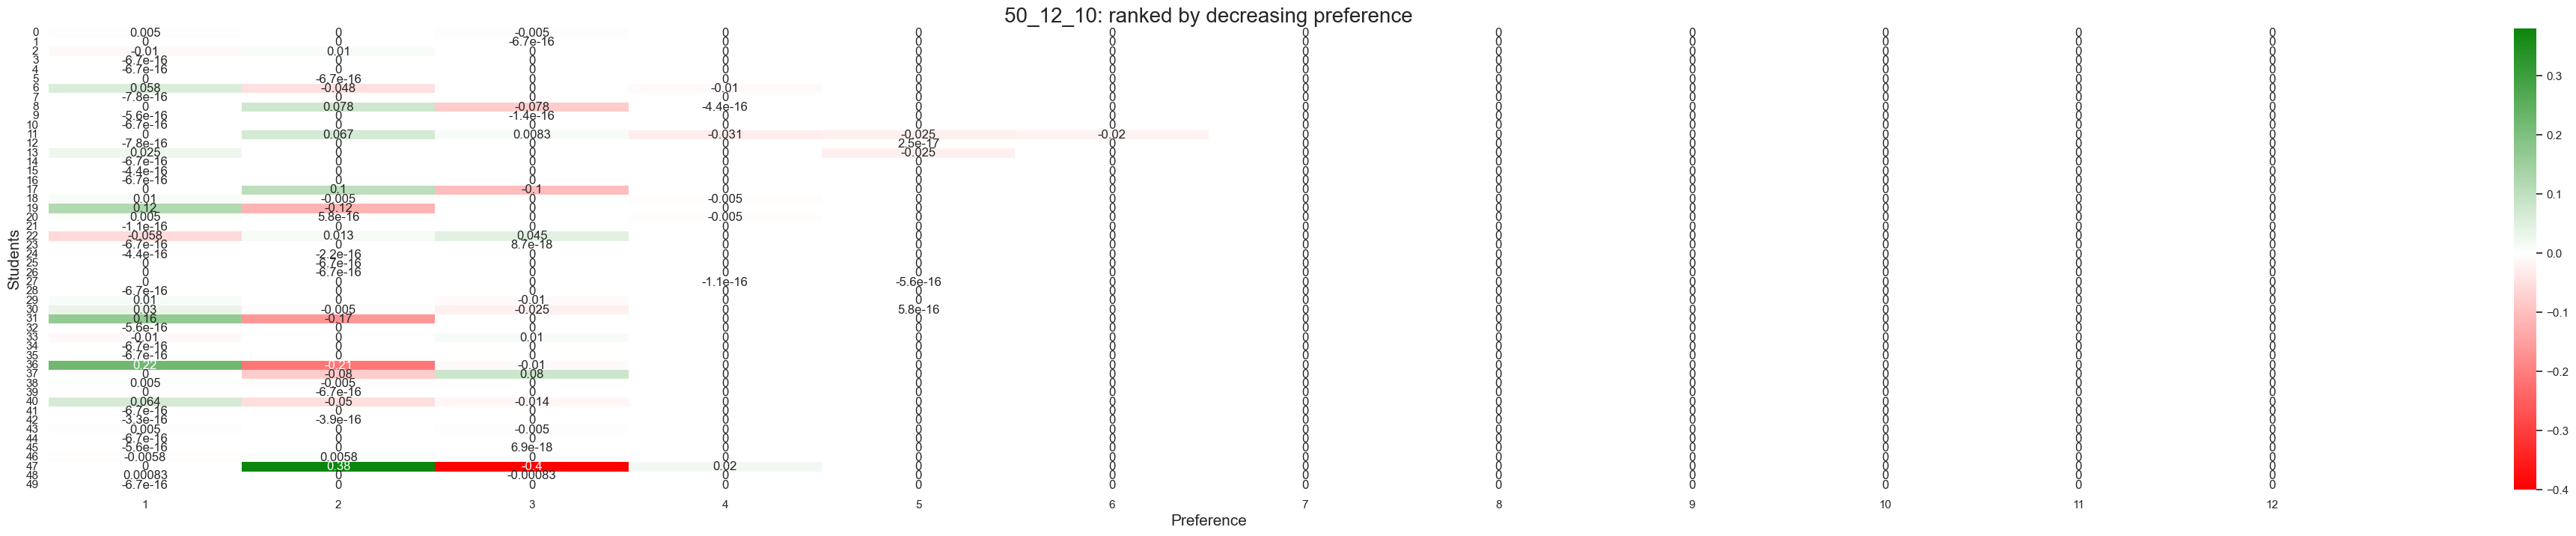

<Figure size 5000x800 with 0 Axes>

In [18]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, S.A.assignment - S.A_DA_prob, name_diff)
diffEE = Assignment(MyData, S.A.assignment - S.A_SIC.assignment)
diff.visualize()
diffEE.visualize()

In [19]:
# Compare resulting assignment with DA
result = S.A.compare(S.A_DA_prob)
resultEE = S.A_SIC.compare(S.A_DA_prob)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


Number of improving students EE & us 25 25
Average improvement rank EE & us 0.13199999999999912 0.1895999999999997
Median rank improvement 0.07999999999999974 0.11833333333333318


# Column generation Erdil & Ergin data

In [7]:
n_stud = 50
n_schools = 6
pref_list_length = n_schools
alpha_in = 0.2
beta_in = 0
seed = 0
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)

The data instance has the following properties: 

	50 students.
	6 schools. 

 	PREFERENCES:
	0	4 3 1 5 2 0 
	1	0 1 5 3 4 2 
	2	1 3 2 5 0 4 
	3	5 1 4 0 3 2 
	4	1 2 3 5 0 4 
	5	5 2 1 4 3 0 
	6	0 5 4 1 2 3 
	7	3 1 2 0 4 5 
	8	1 2 4 5 3 0 
	9	3 5 1 2 0 4 
	10	1 2 4 5 3 0 
	11	5 0 2 3 4 1 
	12	3 4 1 5 2 0 
	13	4 3 1 0 5 2 
	14	4 1 2 5 3 0 
	15	4 1 3 2 5 0 
	16	5 0 4 1 2 3 
	17	3 4 1 2 0 5 
	18	5 4 1 2 0 3 
	19	1 3 2 0 4 5 
	20	5 1 4 3 2 0 
	21	1 5 2 3 4 0 
	22	4 2 5 3 1 0 
	23	2 1 0 4 5 3 
	24	5 2 3 0 4 1 
	25	4 2 3 1 5 0 
	26	5 4 3 0 1 2 
	27	2 1 5 0 4 3 
	28	3 2 1 4 0 5 
	29	4 1 3 2 5 0 
	30	1 3 2 4 0 5 
	31	5 2 3 4 1 0 
	32	5 0 3 2 4 1 
	33	2 3 4 1 0 5 
	34	0 4 5 3 2 1 
	35	1 3 2 5 4 0 
	36	1 2 0 3 4 5 
	37	3 2 1 5 0 4 
	38	2 1 4 0 5 3 
	39	1 2 5 3 4 0 
	40	5 3 2 1 0 4 
	41	3 5 0 2 4 1 
	42	5 4 1 2 0 3 
	43	2 4 0 5 3 1 
	44	3 2 0 1 5 4 
	45	0 3 1 2 5 4 
	46	1 3 0 2 5 4 
	47	1 4 3 2 5 0 
	48	3 1 0 4 5 2 
	49	2 1 5 3 0 4 


 	CAPACITIES & PRIORITIES:
	0	9	{2 3 5 8 13 32 33 34 37 41 44} {0

In [8]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 200
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)

Students in ties: 50
Tie-breaking rules needed: 30414093201713378043612608166064768844377641568960512000000000000
Tie-breaking rules sampled: 200


Generate DA_STB: 100%|██████████| 200/200 [00:00<00:00, 518.71perturb/s]


STATISTICS BEFORE:

Average rank: 1.2164000000000004.

STATISTICS AFTER:

Average rank: 1.2076000000000005.



In [9]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
    # Will use matchings in A_SIC to sd_dominate the assignment 'A.assignment' (found by DA)
    
q = MyModel.Solve("TRAD", "GUROBI", print_log=False, time_limit= 15, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

Master: add decision variables: 100%|██████████| 200/200 [00:00<00:00, 932.19var/s]



Average rank DA : 1.2164000000000004.


Average rank warm start solution : 1.2076000000000005.




Pricing exclude found matchings: 100%|██████████| 200/200 [00:00<00:00, 530.59matchings/s]


Number of matchings: 200
ITERATION: 1

 ****** MASTER ****** 

Objective master:  1.1812000000000002
Constant term 0.019999999999959987

 ****** PRICING ****** 

Set parameter BestObjStop to value -1.9899999999959988e-02
		Objective pricing:  3.6400000000001262
New number of matchings: 201
ITERATION: 2

 ****** MASTER ****** 

Objective master:  1.181200000000001
Constant term 0.019999999999986792

 ****** PRICING ****** 

Set parameter BestObjStop to value -1.9899999999986793e-02
		Objective pricing:  3.560000000000035
New number of matchings: 202
ITERATION: 3

 ****** MASTER ****** 

Objective master:  1.1812000000000007
Constant term 0.019999999999999154

 ****** PRICING ****** 

Set parameter BestObjStop to value -1.9899999999999154e-02
		Objective pricing:  3.540000000000001
New number of matchings: 203
ITERATION: 4

 ****** MASTER ****** 

Objective master:  1.1812000000000005
Constant term 0.019999999999999796

 ****** PRICING ****** 

Set parameter BestObjStop to value -1.98999

In [14]:
# Compare resulting assignment with DA
result = q.compare(A.assignment)
resultEE = A_SIC.compare(A.assignment)
print(resultEE)
print(result)
print("Number of improving students EE & us", resultEE['n_students_improving'], result['n_students_improving'])
print("Average improvement rank EE & us", resultEE['average_rank_increase'], result["average_rank_increase"])
print("Median rank improvement", resultEE['median_rank_improvement'], result['median_rank_improvement'])


{'students_improving': [False, False, False, True, False, True, False, False, False, True, True, False, False, True, True, False, False, True, True, True, True, True, False, False, False, True, True, False, True, True, True, True, False, False, False, True, False, True, False, True, True, False, True, False, False, False, False, True, False, False], 'n_students_improving': 23, 'rank_increase_by_stud': [0, 0, 0, 0.00999999999999912, 0, 0.014999999999999236, 0, 0, 0, 0.004999999999999449, 0.00999999999999912, 0, 0, 0.004999999999999227, 0.01999999999999935, 0, 0, 0.024999999999999467, 0.004999999999999227, 0.024999999999999467, 0.034999999999999254, 0.034999999999999254, 0, 0, 0, 0.014999999999999236, 0.004999999999999227, 0, 0.009999999999999343, 0.009999999999999343, 0.014999999999999236, 0.04499999999999926, 0, 0, 0, 0.004999999999999005, 0, 0.009999999999999343, 0, 0.04999999999999938, 0.009999999999999343, 0, 0.014999999999999014, 0, 0, 0, 0, 0.059999999999999165, 0, 0], 'average_ra

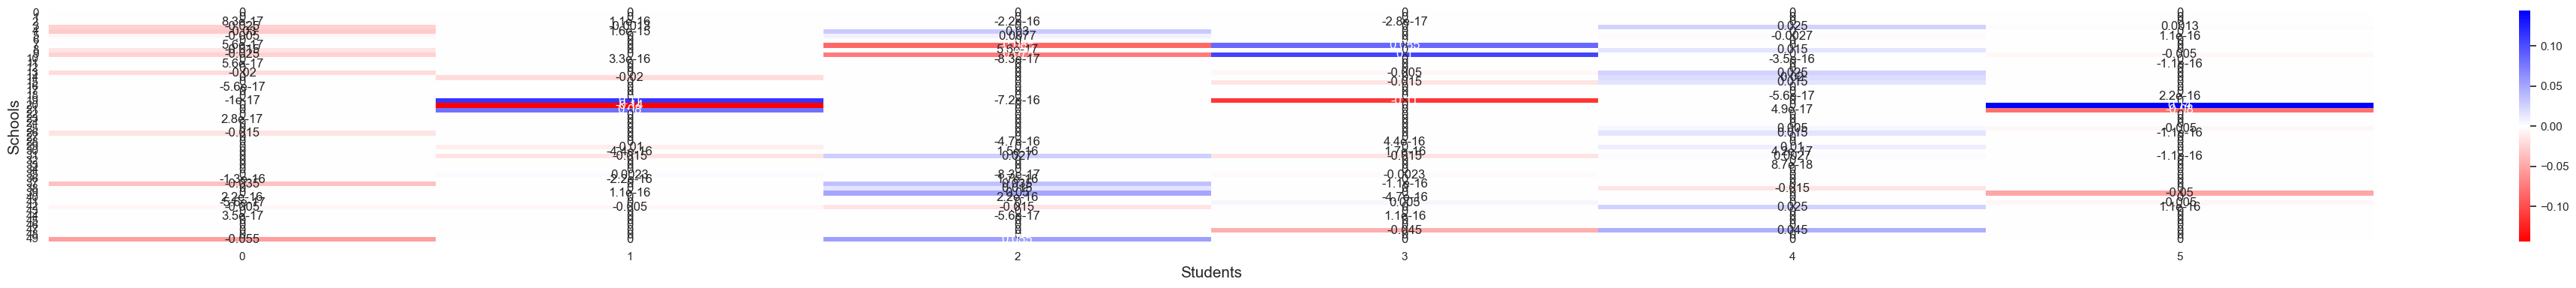

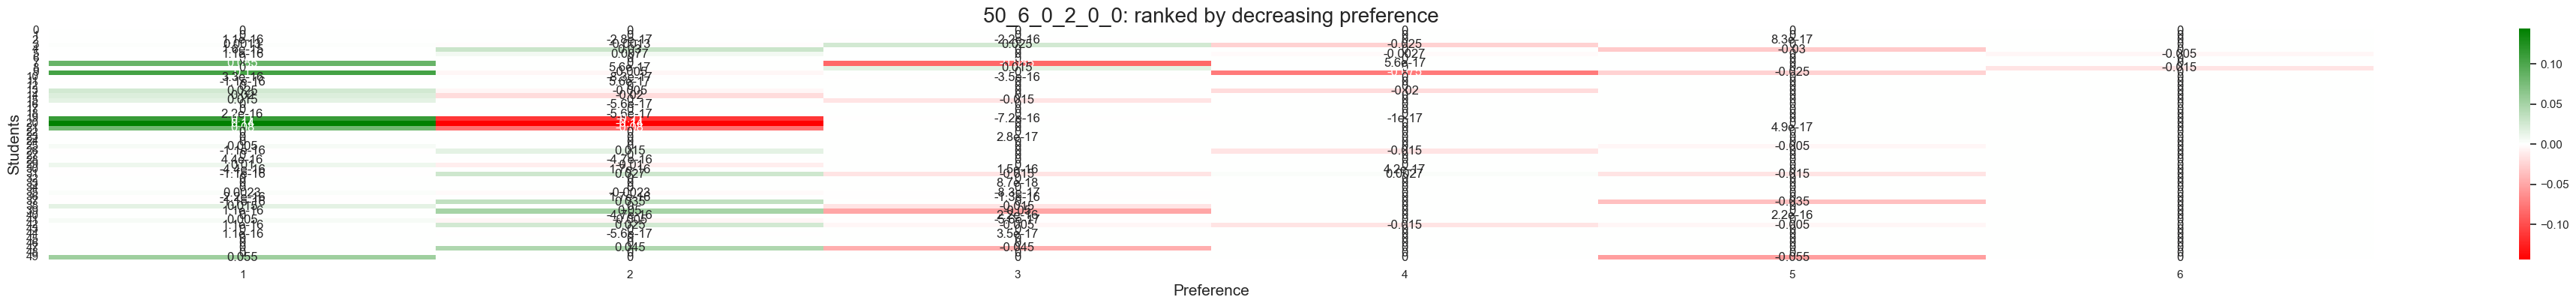

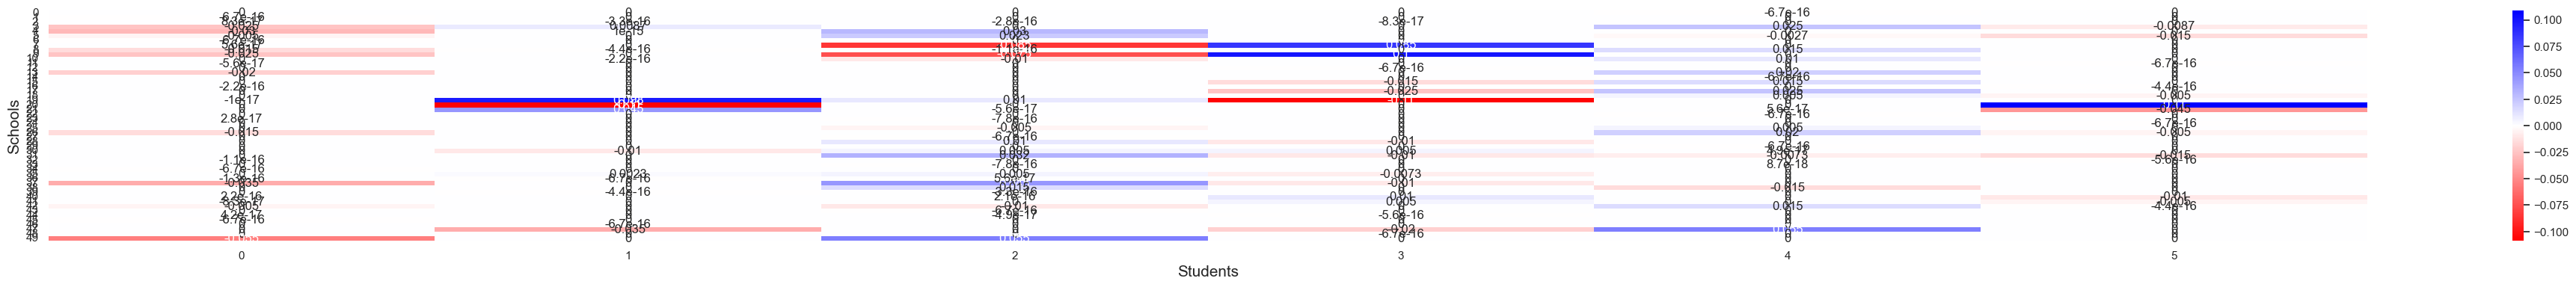

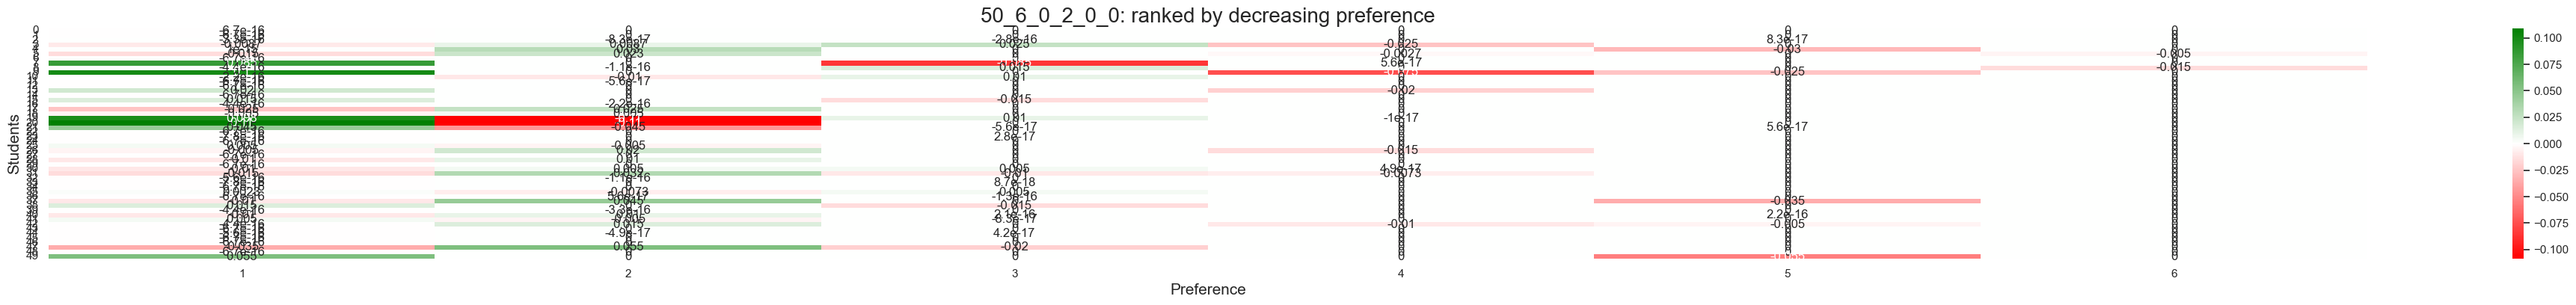

<Figure size 5000x400 with 0 Axes>

In [ ]:
# Asses and visualize the difference
name_diff = MyData.file_name + '_diff'
diff = Assignment(MyData, q.assignment - A.assignment, name_diff)
diffEE = Assignment(MyData, q.assignment - A_SIC.assignment)
diff.visualize() # Difference compared to DA
diffEE.visualize() # Difference compared to EE

## Estonian data

In [ ]:
file_path = "ReadData/Estonia/data_anon.txt" 
MyData = read_dataEstonia(file_path)
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = False # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)

# Find Stable improvement cycles à la Erdil and Ergin (2008)
A_SIC = SIC_all_matchings(MyData, A, True)
print(A.assignment)

In [ ]:
# Solve the formulations
MyModel = ModelColumnGen(MyData, A_SIC, A.assignment, True)
timeLimit = 3600
q = MyModel.Solve("TRAD", "GUROBI", print_log=False, time_limit=timeLimit, print_out=True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Generate a second subset of matchings, and test column generation with that
# (10 June 2025: not yet configured for use of warm start)
n_iter = 1000
bool_SIC = True # Run SICs immediately?
B = DA_STB(MyData, n_iter, 'GS', bool_SIC, 1, True)
B_SIC = SIC_all_matchings(MyData, B, True)
A_SIC.M_set = copy.deepcopy(B_SIC.M_set)
MyModel2 = ModelColumnGen(MyData, A_SIC, A.assignment, True)
qq = MyModel2.Solve("TRAD", "GUROBI", print_log=True, print_out=False)


## Run initial IP on generated data
Specify the number of students and schools, and run the models for this data.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 6, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=1000, n_schools=50, parameters = parameters, name="Test_DataGen_EE_vs_GS", print_data=False, seed = 0)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 20
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
name_diff = name + '_diff'
diff = Assignment(MyData, q.assignment - A.assignment, name_diff)
diff.visualize()

## Heuristic subset weakly stable matchings
Runs an LP that minimizes the average rank while stochastically dominating the DA assignment with single-tie breaking, and while only using matchings that were used to compute DA probabilities. This is a heuristic.

In [ ]:
# Generate random data
parameters = DataGenParam(mean_pref = 5, capacity_ratio = 1) # Default parameters, except for mean_pref and capacity_ratio
#MyData = generate_data(n_students=400, n_schools=20, parameters = parameters, name="Test_DataGen", print_data=False, seed = 15)
MyData = generate_data(n_students=10, n_schools=4, parameters = parameters, name="500_25", print_data=False, seed = 1)

In [ ]:
# Print data if desired
print(MyData)

In [ ]:
# Generate the assignment from DA with Single Tie-Breaking with n_iter samples
n_iter = 1000
bool_SIC = True # Run SICs immediately?
A = DA_STB(MyData, n_iter, 'GS', bool_SIC, 0, True)
print(A.assignment)

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModel = ModelHeuristicLP(MyData, A, True)
q = MyModel.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
print(np.max(q.assignment-A.assignment))

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - A.assignment, "40_12_Diff")
diff.visualize()

## Heuristic Fractional stable random matching

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
MyModelFS = ModelFracStable(MyData, A, True)
q = MyModelFS.Solve("IMPR_RANK", "GUROBI", True)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# FInd decomposition over weakly stable matchings of this fractionally stable matching (if decomposition exists)
MyModelCHECK = Model(MyData, q, True)
q_check = MyModelCHECK.Solve("STABLE", "GUROBI", True)

## Run code manual data
Manually enter data.

In [ ]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

In [ ]:
# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


In [ ]:
# Generate an Assignment instance (and visualize it)
A = Assignment(MyData, p, "Ex_paper")

# To visualize assignment
A.visualize()

In [ ]:
# Solve the formulations
    # 'IMPR_RANK' refers to minimizing the expected rank while ensuring ex-post stability
    # 'STABLE' refers to maximizing the fraction of STABLE matchings in the decomposition
MyModel = Model(MyData, A, False)
q = MyModel.Solve("IMPR_RANK", "GUROBI", False)
#q = MyModel.Solve("STABLE", "GUROBI", True)

In [ ]:
# Print the solution
MyModel.print_solution()

In [ ]:
# Asses and visualize the difference
diff = Assignment(MyData, q.assignment - p, "Ex_paper_Diff")
diff.visualize()

In [ ]:
tuple([1,2])

# Erdil & Ergin experiments

In [16]:
# Define preferences of the students
# 'pref[i][k]' contains the position of the k-th ranked school in the preferences.
# We assume the preferences to be strict
# Note that preferences can be strict. We indicate this by a tuple () in the list.

# Example paper
n_stud = 4
n_schools = 4

file_name = "Ex_paper"

# Preferences students
pref = [['1', '3', '4', '2'],
       ['1','4','3','2'],
       # ['1', '4'],
       ['2','3', '4', '1'],
       ['2', '4', '3', '1']]

# Priorities schools
prior = [[('A', 'B'), 'C', 'D'],
        [('C', 'D'), 'A', 'B'],
        ['B', 'D', ('A', 'C')],
        ['A', 'C', ('B', 'D')]]


# Capacities schools
cap = [1,1,1,1]

# Names of students and schools
ID_stud = ["A", "B", "C", "D"]
ID_school = ["1", "2", "3", "4"]

# Also create the random matching upon which we want to improve
p = np.zeros(shape=(n_stud, n_schools))
p[0][0] = 1/2
p[1][0] = 1/2
p[2][1] = 1/2
p[3][1] = 1/2
p[0][2] = 3/8
p[2][2] = 3/8
p[1][3] = 3/8
p[3][3] = 3/8
p[0][3] = 1/8
p[2][3] = 1/8
p[1][2] = 1/8
p[3][2] = 1/8

# Generate a data instance (and print it)
MyData = Data(n_stud, n_schools, pref, prior, cap, ID_stud, ID_school, file_name)
print(MyData)


The data instance has the following properties: 

	4 students.
	4 schools. 

 	PREFERENCES:
	A	1 3 4 2 
	B	1 4 3 2 
	C	2 3 4 1 
	D	2 4 3 1 


 	CAPACITIES & PRIORITIES:
	1	1	{A B} C D 
	2	1	{C D} A B 
	3	1	B D {A C} 
	4	1	A C {B D} 



In [ ]:
# Do tie-breaking
permut = generate_permutations_STB(MyData, 1, seed = 3)

prior_new = generate_strict_prior_from_perturbation(MyData, permut[0])

Data_new_prior = Data(MyData.n_stud, MyData.n_schools, MyData.pref, prior_new, MyData.cap, MyData.ID_stud, MyData.ID_school, MyData.file_name)

# DA code Erdil & Ergin
N = transform_pref_us_to_EE(Data_new_prior)
A = transform_prior_us_to_EE(Data_new_prior)
Q = MyData.cap
result = DA_Erdil_ergin(N,A,Q)
print(result)
print(type(result['proposeoffset']))

M = gale_shapley(Data_new_prior)
print(type(M))
print(M)

M = np.zeros((4,4))
M[0,1] = 1
M[1,2] = 1
M[2,3] = 1
M[3,0] = 1
print(M)
print(M[0,1] == 1)

M_out = SIC(MyData, M, False)
print(M_out)

In [ ]:
bool_SIC = False # Run SICs immediately?
AssignmentGS = DA_STB(MyData, 10, 'GS', bool_SIC, 0)
ASIC = SIC_all_matchings(MyData, AssignmentGS, True)

print(AssignmentGS.assignment)




# Quick tests


In [28]:
n_stud = 2000
n_schools = 30
pref_list_length = n_schools
alpha_in = 0.2
beta_in = 0
seed = 1
MyData = DataGenEE(n_stud, n_schools, alpha_in, beta_in, pref_list_length, True, seed)
print(MyData)


The data instance has the following properties: 

	2000 students.
	30 schools. 

 	PREFERENCES:
	0	11 6 28 0 12 9 18 8 21 3 23 25 1 16 20 2 13 7 19 14 22 26 4 29 17 27 10 5 24 15 
	1	20 24 0 16 25 9 22 12 26 8 6 5 2 19 28 23 27 17 11 10 15 7 21 4 3 29 13 18 1 14 
	2	10 2 0 19 6 8 5 13 21 17 4 20 22 7 18 23 3 14 26 16 25 15 29 27 9 1 24 28 11 12 
	3	22 25 7 24 20 3 9 13 1 27 21 19 26 29 23 14 12 28 4 2 0 16 18 11 8 17 6 5 15 10 
	4	17 2 8 26 20 7 24 14 11 27 29 6 5 23 19 13 0 15 10 12 9 21 18 22 25 4 3 28 16 1 
	5	8 24 28 10 19 23 5 22 25 2 29 4 12 13 9 18 11 0 3 20 26 7 14 6 16 21 1 27 15 17 
	6	25 22 28 5 29 0 6 8 23 3 15 12 4 18 21 14 20 17 7 9 1 11 16 24 27 2 19 13 26 10 
	7	5 29 7 27 8 22 18 26 20 23 3 25 15 9 0 19 17 13 10 12 6 4 2 16 14 28 1 11 21 24 
	8	22 14 29 8 24 5 21 27 13 1 0 12 16 15 2 3 23 4 11 7 26 28 18 25 9 6 19 10 20 17 
	9	13 14 28 21 15 18 29 2 17 9 22 6 8 11 4 0 24 19 20 7 26 25 5 10 23 12 3 16 1 27 
	10	13 24 4 15 25 17 16 0 20 5 1 7 11 19 6 29 22 9 14 28 18 2 12